# CNNs and Computer Vision
##### By Cody Bellamy

In this notebook, we will explore, break down, and analyze the structures and reasoning behind a typical CNN and the components that go into creating a CNN. This notebook assumes the reader has a entry-level understanding of artificial neural networks and related algorithms.

## Prerequisites
1. [Python](https://www.python.org/downloads/)
2. [PyTorch](https://pytorch.org/get-started)

## The Data
It is important to understand the data that you will be working with. When working with images, typically the image is broken down into 3 dimensions: height, width, and channels. A channel can be thought of as a layer. With many layers stacked on top of each other, we can construct an image. A typical image consists of 3 channels (RGB). You can imagine that we can remove all the red values for each pixel and construct a new image consisting of only red pixels of varying brightness. We can further extract the green and blue channels from the image. For the purposes of this notebook, we will consider only .jpg images with 3 RGB channels. A CNN does not care so much for color as it does for features. In this sense, it is important to normalize our images against the mean and std across our training data. Each input is a linear combination of all channels and then a dot product with the kernels to create new images. More on this process later. For now, we need to consider that for our data, we need to normalize the channels to get more meaningful data from our inputs. For the purposes of this notebook, we will be using pre-calculated normalizations for the data.

To get started, we are going to import some packages we plan on using for this CNN.

In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

Next, we are going to define the transformations that will be performed on our input images. Some transformations will be to consolidate the size, other transformations will be done to the values of the pixels for normalizations. As shown below, we can simulate "new" data using the same images by adding 4 pixels of padding and cropping randomly in a 32x32 area. We can additionally decide to horizontally flip the image. The last step is to normalize our data with the means and stds calculated for each channel beforehand.

**Note:** We are assuming all inputs have the same dimensions for height, width, and channels. If your input is of different sizes, random crop will work for traning; but, you must call transforms.resize() for your testing data before converting to a tensor.

A tensor object is simply a matrix with variable number of dimensions. Tensors have what is called a "shape" and the shape of a tensor object can be viewed by calling the object variable "shape". EG: `print(myTensor.shape)`

In [8]:
# Set up data for training and testing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

Now to load our data for this example, we are going to be using the CIFAR10 dataset. PyTorch allows for your code to download and utilize the CIFAR10 dataset. Note that we are assigning the transformations we composed in the last step to the data we are loading.

`num_workers` refers to how many processes/batches you are going to run in parallel. If `num_workers` is greater than 0, I recommend encapsulating all of your code in a main function and running the following code to prevent infinite recursion.
```
def run():
    torch.multiprocessing.freeze_support()
    main()
if __name__ == '__main__':
    run()
```

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


Finally, we need to define what categories we will be classifying. If you are working with your own data and these are all placed into seperate folders, you can name each class what you named the folders. Otherwise, we will use the same structure that is used in CIFAR10.

In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## CNN Structure

Now that we have set up our data, we now need to define the structure of our CNN. This can be broken down into two parts. The first part are our convolutional blocks. The second part is a fully connected neural network to process the outputs of our convolutions.

### Convolutional Blocks
Convolutional blocks are a series of steps that are repeated for extracting the most feature information. The number of blocks depends on the size of the images, the features you are trying to extract, and the computational constraints of your resources. Typically, one block consists of the convolutions, normalizations, an activation, a second set of convolutions, another activation, and finally a pooling function. This structure helps to maintain a balance of retaining important feature data derived from the convolutions and reducing the number of inputs to the next layer.

Let's break down a 2D convolution in terms of our CNN. The first step is to generate our kernels (filters). These are randomly generated in PyTorch. Each kernel is designed to extract some unknown features from our input channels. There are some considerations to make when determining the size of our kernels for any particular convolution. If the features we are trying to classify are sometimes near the borders of the image, it might be necessary to pad our input channels with some pixels. If the defining features are particularly large, we may want our kernels to be larger. There are many variables to consider when designing a convolutional layer. In our example, our images are particularly small with more intricate features that help to classify our images. In our example, there are particularly small features that define our images. We will set our `kernel_size=3` and `padding=1` for all layers.

When a convolution is done, we will first "stack" the input channels on top of eachother. Next, a linear combination of each pixel is calculated using the weights of the network. This essentially will squash our 3rd dimension (channels). In doing so, the shape of our input becomes only width and height. Finally, the kernels are passed over, one at a time, the entire image performing dot products to produce the new images. The output of each convolution with each different kernel becomes a new channel. Thus, if we have 3 input channels and 32 output channels, we will need 32 kernels to create a new shape. Since our padding of 1 pixel and kernel size of 3 pixels is constant, we will generate a 31x31x32 output shape. The more kernels we use, the more features we can isolate from our image such as vertical lines, horizontal lines, changes in contrast, etc.

With this information, we can construct our first step in the convoultional block.
`nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)`

We then normalize our data using all 32 output channels produced from this convolution and apply an activation. ReLU is fast, and efficient in classifier networks.
```
nn.BatchNorm2d(32)
nn.ReLU(inplace=True)
```
**Note:** we use `inplace=True` to help preserve memory. Our input data will be lost and replaced with the output of our activation. This paramter is telling PyTorch that we do not care to save the input values.

We can repeat our convolutions and another activation.
```
nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
nn.Relu(inplace=True)
```

And finally, we are going to pool our output from this block. Pooling is not a necessary step if you have the computational power. Although, if you have been keeping track, our current tensor shape until this point is 30x30x64. As we continue convolving, normalizing, and applying activations, the computational strain will be exponential. Thus, we are going to pool the data we have. If we perform max pooling, we will take the max value from a section and this becomes the new value of a new image. With max pooling, we have two parameters that we can control. `kernel_size` and `stride`. A 2x2 kernel with a stride of 2 will take the max of a 2x2 grid, then stride 2 pixels to the next adjacent 2x2 grid and take the max of those. We can reduce the image size by a factor of 4. The output shape of our max pooling will result in 15x15x64. This is much more manageable and retains most of the important data. So our code for the block becomes:
`nn.MaxPool2d(kernel_size=2, stride=2)`

For CIFAR10, we are going to repeat these blocks twice more for 3 total convolutional blocks. The code below is a snippet from the network class (which we will construct momentarily).
```
# Conv Layer block 1
nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
nn.BatchNorm2d(32),
nn.ReLU(inplace=True),
nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
nn.ReLU(inplace=True),
nn.MaxPool2d(kernel_size=2, stride=2),

# Conv Layer block 2
nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
nn.BatchNorm2d(128),
nn.ReLU(inplace=True),
nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
nn.ReLU(inplace=True),
nn.MaxPool2d(kernel_size=2, stride=2),
nn.Dropout2d(p=0.05),

# Conv Layer block 3
nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
nn.BatchNorm2d(256),
nn.ReLU(inplace=True),
nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
nn.ReLU(inplace=True),
nn.MaxPool2d(kernel_size=2, stride=2)
```

### The FC Network
After our convolutions have been completed, we will squash our shape into one dimension (4096x1x1) and feed it into a fully connected artificial neural network (FC-ANN). This portion should be more or less self explanitory. Our FC-ANN must have enough layers to properly process the inputs and must have 10 outputs with a softmax activation to determine the network's "confidence" in its classification.
```
nn.Dropout(p=0.1),
nn.Linear(4096, 1024),
nn.ReLU(inplace=True),
nn.Linear(1024, 512),
nn.ReLU(inplace=True),
nn.Dropout(p=0.1),
nn.Linear(512, 10)
```

### Putting it All Together
Finally, with this information and structure, we can design our CNN class. The `forward` function will be called by PyTorch. This function essentially defines what a forward pass looks like for our network.

In [5]:
# Create the CNN and Linear NN structure
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

## Training
Now that we've built our network, it is important to train it. Similar to a FC-ANN, we will take batches from our training set and do forward passes. We can asses the performance of our network against the labels and the perform back propagation. Luckily, PyTorch does a lot of the heavy lifting and optimizations to speed this up. So let's create our network and define our loss function and optimizer.

In [6]:
import torch.optim as optim

# Create an instance of our network
net = Net()

# Optimize and define parameters of our network
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Saving Network States
Before training our network, we are going to define a location and filenames to save our network after training each epoch. Saving our network state allows us to load our trained network in the future to the exact same state (weights and biases) when we want to evaluate inputs later.

**Note: *YOU MUST*** create the `states` folder in the local directory **FIRST**. This script **DOES NOT** create the folder for you. It would not be fun to train an entire epoch first and then experience a runtime error.

In [7]:
PATH = './states/cifar_'

Now that we've done all the setup, it's time to train our network. We want to train our network for only a certain number of epochs. For each epoch, we want to forward pass our batches, back propagate each mini batch, and save our network state at the end of the epoch. Using this information, our training loop looks like this.

In [ ]:
net.train(True) # Set our network to training mode

for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    
    # Save the state of our network
    torch.save(net.state_dict(), PATH+str(epoch+1))
    
    # Test the network after each epoch
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

## Using Pretrained Networks
After successfully training your network, it may become useful to load the state of your network again. In this example, we have trained a network to a high degree of success. The next step is to package our network so that it may be used again using relatively low resource cost. For our example, we will be loading a state of our network that has had 62 epochs of training and reaching diminishing returns on accuracy improvement. The overall accuracy of the network has been calculated to 92% against the test batch.

### Prerequisites
Below are the files that are required for this section. Place them in the same directory as this notebook.
- [LayeredCNN.py](https://github.com/codbellamy/Directed-Study/blob/master/Neural%20Networks/CIFAR10/LayeredCNN.py)
- [State File](https://github.com/codbellamy/Directed-Study/blob/master/Neural%20Networks/CIFAR10/states/3xConv_MaxPool/cifar_net_62)
- An image of your choice from any source (extension cannot be .png)

### Steps
Following these simple steps will demonstrate how to use a pretrained network as a function.
1. Initial setup
2. Load the network
3. Pass the image through
4. Interpret the output

There will be some additional code added for some cool visualizations which will take more processing time and resources. For the purposes of functionality, these steps can be skipped. They will be noted as an optional step.

#### Step 1: Initial setup

In [1]:
# Dependencies
from LayeredCNN import Net
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# If you are planning on plotting the convolution outputs
from math import sqrt
from math import ceil
import matplotlib
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Trained state
STATE_FILE = './cifar_net_62'

# Input image
IMAGE = 'image.jpg'

# Outputs
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

After this point, we need to set up the transformations that will be done to our input images. There are a few key concepts to keep in mind while doing this. Recall that when we trained the network, the tensor shape was 32x32x3. It is crucial that we match this shape **EXACTLY**. If the shape is not the same, there will be a mismatch in our code for the required number of inputs to the actual number of inputs. Additionally, our training and testing data has had its values normalized. Thus, we must also normalize our input data. Luckily, PyTorch proviedes the resources to make these steps easy.

In [2]:
# Transformations and data normalizations to adjust input similar to training data
data_transforms = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

#### Optional: Registering Forward Hooks
The following step is registering forward hooks. Essentially, this is letting PyTorch know that we want to save some values in memory during the forward pass. In our case, we are planning on converting the data between two layers into images. The following function will allow us to create a dictionary of forward hooks called `activation` that we can use to print each activation as an image.

In [3]:
# Create a dictionary of activations for visualizations
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

We are now going to preload our image into memory using our transformations. This step is simply to get everything ready to pass through our network once it is ready.

In [5]:
print('Reading image...')
if IMAGE[-3:] == 'png':
    raise Exception('Extension cannot be png')
image = Image.open(IMAGE) # Image to pass through the network
image_t = data_transforms(image) # Perform transformations to the image
batch_t = torch.unsqueeze(image_t, 0) # Convert the matrix to a vector
print('Done')

Reading image...
Done


#### Step 2: Load the Network

In [8]:
print('Initializing network...')
net = Net() # Create the network, this must be the exact same structure as the trained network
net.load_state_dict(torch.load(STATE_FILE)) # Load the trained state from file
net.eval() # Set the network to evaluation mode
print('Done')

Initializing network...
Done


#### Optional: Register Forward Hooks
Now that our network has been initialized, we are going to register the hooks where we want to monitor the data. I have chosen the indexes within `self.conv_layer` where I want to register a hook at the output. Each index value corresponds to each layer. 17 was chosen because it is the output of the final max pooling step prior to feeding into the FC-ANN. I belive it would be interesting to see a visualization of the data after all convolutions have finished.
**Note:** If you plan on doing this optional step, the previous optional step is required.

In [9]:
# Register forward pass hooks for each convolutional layer in the sequence
CONV_LAYERS = (0,3,7,10,14,17)
for layer in CONV_LAYERS:
    name = 'conv_layer'+str(layer)
    net.conv_layer[layer].register_forward_hook(get_activation(name))

#### Step 3: Pass the Image Through
Now that we have everything all set up, it's time to pass our image through the network. Since we've done all the hard work already, this step is very easy.

In [10]:
print('Processing image...')
out = net(batch_t) # Run the transformed image through the network
_, index = torch.max(out, 1) # Read outputs
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100 # Convert outputs to percentages
print('Done')

Processing image...
Done


#### Step 4: Interpret the Output
Finally, we need to get our output in a useable format. Most of that will be up to which data type is most useful for you. For the purposes of this example, I will be displaying all 10 categories along with the percentages.

In [12]:
_, indices = torch.sort(out, descending=True)
print('Outputs\n')
for classification in enumerate([(classes[idx], percentage[idx].item()) for idx in indices[0]], start=1):
    print('{0:d}:\t{1:s}\t{2:3.3f}%'.format(classification[0],classification[1][0], classification[1][1]))

Outputs

1:	ship	100.000%
2:	plane	0.000%
3:	truck	0.000%
4:	bird	0.000%
5:	horse	0.000%
6:	car	0.000%
7:	deer	0.000%
8:	cat	0.000%
9:	frog	0.000%
10:	dog	0.000%


#### Optional: Processing Images from Forward Hooks
If you've been keeping up with the visualization step, we've successfully completed a forward pass. Since we've registered hooks, the data has been capture at the points we've denoted earlier. Now we need a way to process this data into images. To do this we are going to loop through our `activations`. For the purposes of this example (and to save time), we are only going to view 4 images for each layer. If you want to see how many channels are in the activation, use `act.size(0)`.


Processing convolutional feature map visualization...
Showing activation for conv_layer0


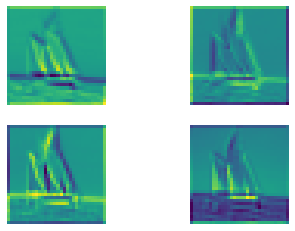

Showing activation for conv_layer3


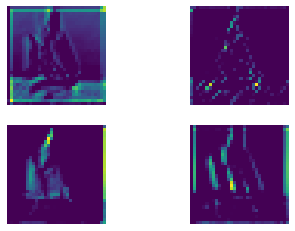

Showing activation for conv_layer7


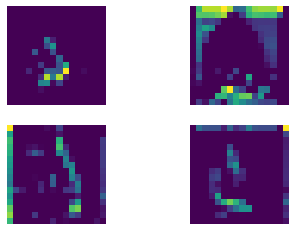

Showing activation for conv_layer10


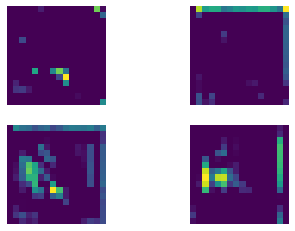

Showing activation for conv_layer14


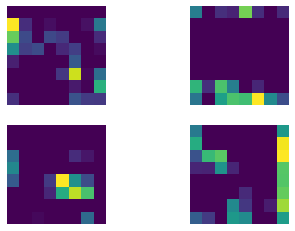

Showing activation for conv_layer17


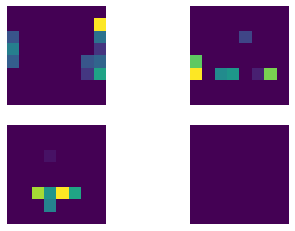

Done


In [17]:
# Save images of feature maps
print('\nProcessing convolutional feature map visualization...')
for name in activation:
    print('Showing activation for {0:s}'.format(name))
    act = activation[name].squeeze()

    # Create a "square" grid for matplotlib
    size = 4
    fig, axarr = plt.subplots(2, 2)
    i = 0
    j = 0
    for idx in range(size):
        axarr[j][i].axis("off")
        axarr[j][i].imshow(act[idx])
        i += 1
        if idx % 2 == 1:
            i = 0
            j += 1
    plt.show()
print('Done')

#### Optional: Visualizing the Kernels
To visualize the kernels, we do not need to register forward hooks. Since kernels are randomly generated and are not input dependent, these values can be taken directly from an instance of a network. In the following steps, we will visualize all 32 of the kernels used in the first convolutions.


Processing kernel visualization...
Done


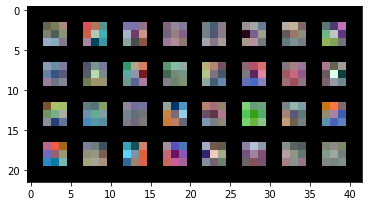

In [18]:
# Show one example of the kernels used to perform convolutions
print('\nProcessing kernel visualization...')
kernels = net.conv_layer[0].weight.detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
img = make_grid(kernels)
plt.imshow(img.permute(1, 2, 0))
print('Done')